In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from tabulate import tabulate

In [2]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class MyBlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.state_size = (32 * 11 * 2) # пространство состояний
        self.action_space_size = (32 * 11 * 2, 2) # пространство состояний и действий
        
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self.get_state_index(), reward, done, {}

    def get_state_index(self):
        return sum_hand(self.player) + 32 * self.dealer[0] + 32 * 11 * usable_ace(self.player)

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self.get_state_index()

In [3]:
env = MyBlackjackEnv(natural = True)

**1.** Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [4]:
# прогон одной игры
def run_episode(env, pi):
    env.reset()
    states, actions, rewards = [], [], []
    for _ in range(1000):
        state_index = env.get_state_index()
        pi_probabilities = pi[state_index]
        next_action = np.random.choice(np.arange(len(pi_probabilities)), p = pi_probabilities)
        _, reward, done, _ = env.step(next_action)
        states.append(state_index)
        actions.append(next_action)
        rewards.append(reward)
        if done:
            break
    return states, actions, rewards

# сгенерировать 19-20-21 стратегию
def generate_simple_strategy(env):
    pi = np.zeros(env.action_space_size)
    for i in range(0, 32):
        for j in range(0, 11):
            for k in range(0, 2):
                hand_sum = i
                if k == 1:
                    hand_sum += 10
                if (hand_sum <= 21) and (hand_sum >= 19):
                    pi[i + 32 * j + 32 * 11 * k][1] = 1
                else:
                    pi[i + 32 * j + 32 * 11 * k][0] = 1
    return pi

# вычислить среднюю награду за стратегию и отобразить график 
def test_policy_and_plot(env, pi, iterations = 1000000):
    avg_rewards = []
    reward_sum = 0
    for i in tqdm(range(iterations)):
        _, _, rewards = run_episode(env, pi)
        reward_sum += np.array(rewards).sum()
        avg_rewards.append(reward_sum / (i + 1))
    plt.figure(figsize=(16, 8))
    plt.plot(avg_rewards[100:])
    plt.ylabel('avg reward')
    plt.xlabel('iterations')
    plt.title("19-20-21 policy")
    plt.grid(axis = "y")
    plt.show()
    print("Policy reward " +  str(avg_rewards[-1]))

100%|██████████| 1000000/1000000 [01:00<00:00, 16443.46it/s]


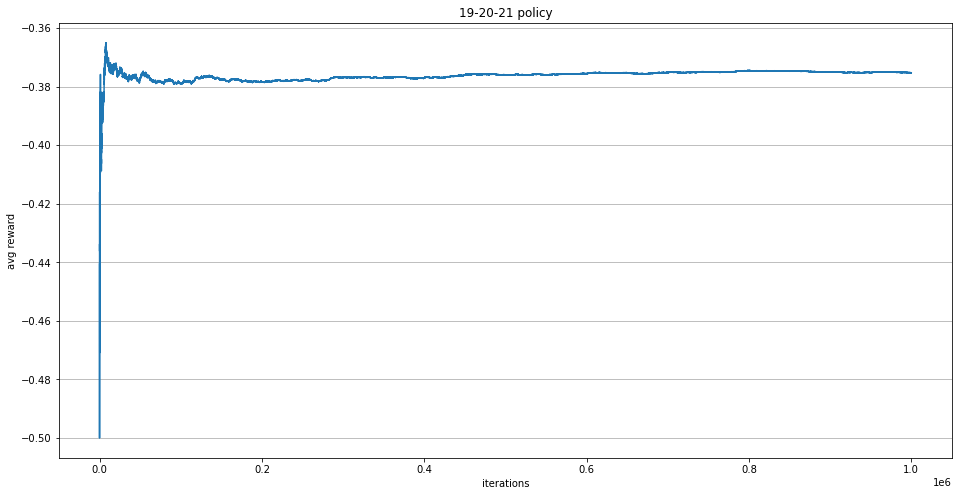

Policy reward -0.375278


In [5]:
pi_19_20_21 = generate_simple_strategy(env)
test_policy_and_plot(env, pi_19_20_21)

**2.** Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [6]:
# Monte-Carlo control with importance sampling

# вычислить начальную жадную стратегию
def get_greedy_policy(Q):
    pi = np.zeros(Q.shape, dtype = float)
    best_action = np.argmax(Q, axis = 1)
    for i in range(Q.shape[0]):
        pi[i][best_action[i]] = 1.0
    return pi

# вычислить стратегию по алгоритму MC control with importance sampling 
def MC_control_importance_sampling(env, episode_count, gamma = 1.0):
    Q = np.random.random(size = env.action_space_size)
    greedy_pi = get_greedy_policy(Q) # жадная стратегия
    if hasattr(env, 'pi'):
        env.pi = greedy_pi
    uniform_rand_probability = 1.0 / env.action_space_size[-1]
    exploration_pi = np.zeros(env.action_space_size) # случайная стратегия
    exploration_pi.fill(uniform_rand_probability)

    Returns = np.zeros(env.action_space_size, dtype=float)
    Counts = np.ones(env.action_space_size, dtype=int)

    greedy_rewards = []
    greedy_reward_sum = 0.0
    
    for i in tqdm(range(episode_count)):
        states, actions, rewards = run_episode(env, exploration_pi)
        w = 1.0
        G = 0.0
        for j in range(len(states) - 1, -1, -1):
            state = states[j]
            action = actions[j]
            reward = rewards[j]
            G = gamma * G + reward
            Counts[state][action] += w
            Q[state][action] += (w / Counts[state][action]) * (G - Q[state][action])
            best_action = np.argmax(Q[state])
            for k in range(0, env.action_space_size[-1]):
                greedy_pi[state][k] = 0
            greedy_pi[state][best_action] = 1
            if action != np.argmax(greedy_pi[state]):
                break # несовпадение действия с жадной стратегией
            w = w * 1./ uniform_rand_probability
        _, _, greedy_reward = run_episode(env, greedy_pi)
        greedy_reward_sum += np.array(greedy_reward).sum()
        greedy_rewards.append(greedy_reward_sum / (i + 1))
    return greedy_pi, greedy_rewards

In [7]:
# вычислить стратегию и отрисовать график изменения средней награды за время вычисления стратегии
def calc_pi_and_plot(env, calculate_fn, plot_title, iterations = 10_000_000):
    pi, rewards = calculate_fn(env, iterations)
    plt.figure(figsize=(16, 8))
    plt.plot(rewards[100:])
    plt.ylabel('avg reward')
    plt.xlabel('iteration')
    plt.title(plot_title)
    plt.grid(axis = "y")
    plt.show()
    print("Average reward while learning " + str(rewards[-1]))
    return pi

# вычислить награду за стратегию
def test_pi(env, pi):
    reward_sum = 0
    for _ in range(1_000_000):
        _, _, rewards = run_episode(env, pi)
        reward_sum += np.array(rewards).sum()
    print("Policy reward " +  str(reward_sum / 1_000_000))

100%|██████████| 10000000/10000000 [28:27<00:00, 5855.10it/s]


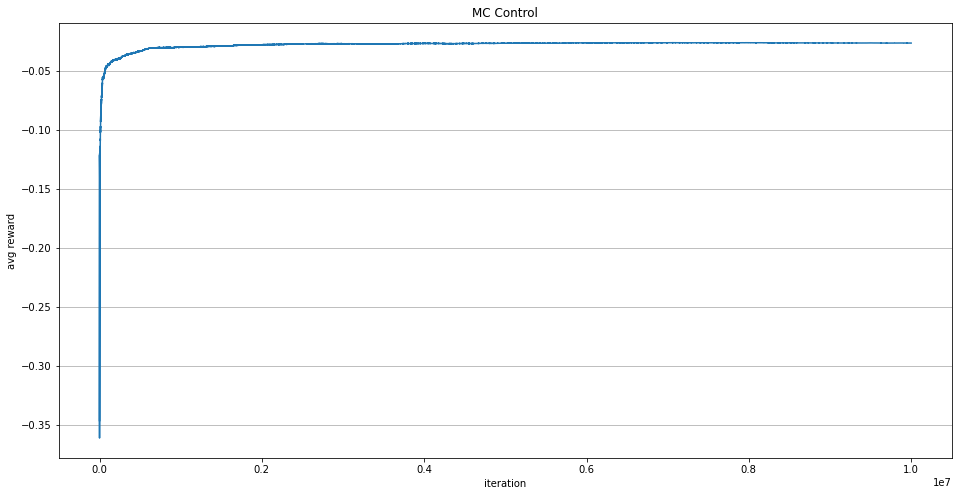

Average reward while learning -0.02619195
Policy reward -0.0254285


In [25]:
pi_mc_env = calc_pi_and_plot(env, MC_control_importance_sampling, "MC Control")
test_pi(env, pi_mc_env)

In [8]:
# Q learning

# вычислить стратегию по алгоритму Q learning
def q_learning(env, episode_count, gamma=0.8, alpha=0.04, epsilon=0.3, enable_tqdm=True):
    
    Q = np.random.random(size = env.action_space_size)
    greedy_pi = get_greedy_policy(Q) # жадная стратегия
    if hasattr(env, 'pi'):
        env.pi = greedy_pi
    uniform_rand_probability = 1.0 / env.action_space_size[-1]
    exploration_pi = np.zeros(env.action_space_size) # случайная стратегия
    exploration_pi.fill(uniform_rand_probability)
    
    greedy_rewards = []
    greedy_reward_sum = 0.0
    
    for i in tqdm(range(episode_count)) if enable_tqdm else range(episode_count):
        env.reset()
        for _ in range(100):
            state_index = env.get_state_index()
            random = np.random.random()
            pi = exploration_pi if epsilon >= np.random.random() else greedy_pi
            pi_probabilities = pi[state_index]
            next_action = np.random.choice(np.arange(len(pi_probabilities)), p = pi_probabilities)
            _, reward, done, _ = env.step(next_action)
            # q_learning
            best_next_action = np.argmax(greedy_pi[state_index])
            target = reward + gamma * Q[state_index][best_next_action]
            delta = target - Q[state_index][next_action]
            Q[state_index][next_action] += alpha * delta
            best_action = np.argmax(Q[state_index])
            for k in range(0, env.action_space_size[-1]):
                greedy_pi[state_index][k] = 0
            greedy_pi[state_index][best_action] = 1
            if done:
                _, _, reward = run_episode(env, greedy_pi)
                greedy_reward_sum += np.array(reward).sum()
                greedy_rewards.append(greedy_reward_sum / (i + 1))
                break
    return greedy_pi, greedy_rewards

100%|██████████| 10000000/10000000 [28:48<00:00, 5785.95it/s]


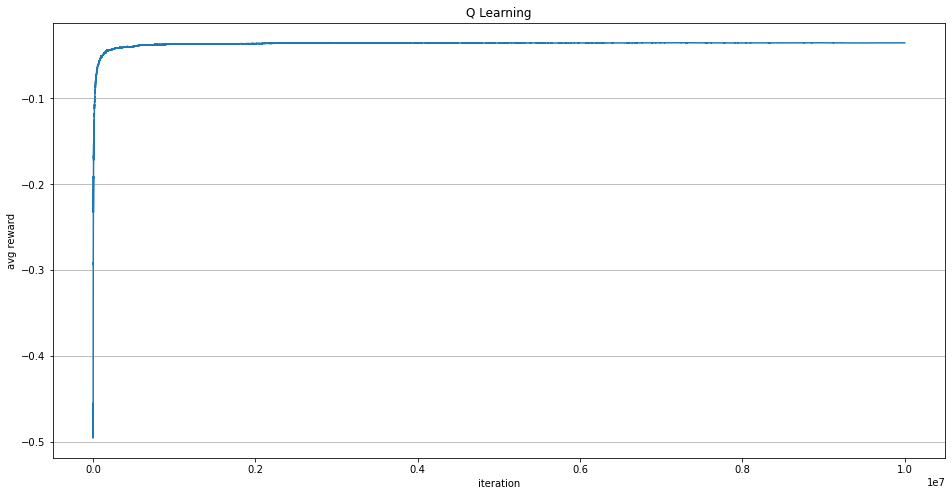

Average reward while learning -0.0353292
Policy reward -0.032569


In [26]:
pi_q_env = calc_pi_and_plot(env, q_learning, "Q Learning")
test_pi(env, pi_q_env)

**3.** Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [11]:
gammas = [0.5, 0.8, 0.9, 0.95, 1.0]
alphas = [0.001, 0.01, 0.01, 0.02, 0.04, 0.16]
epsilons = [0.05, 0.1, 0.3, 0.5]

100%|██████████| 1000000/1000000 [02:42<00:00, 6139.91it/s]


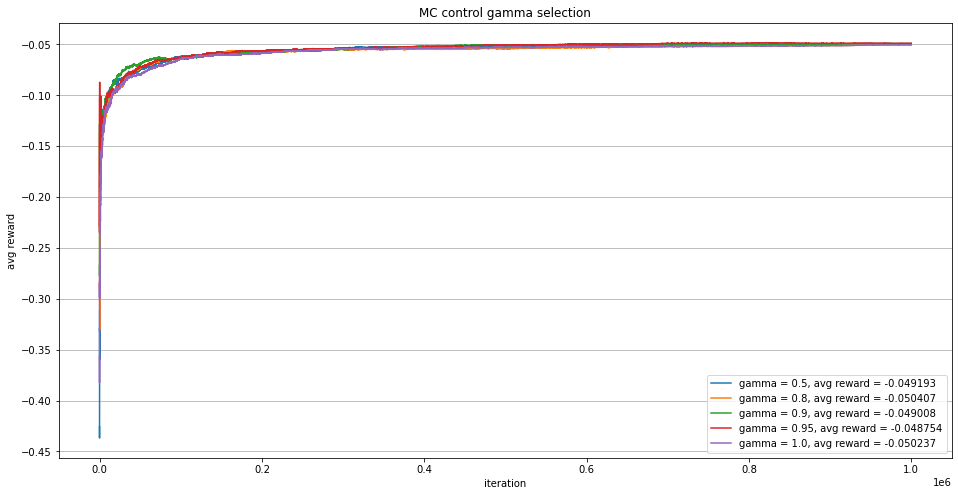

In [12]:
# MC control

plt.figure(figsize=(16, 8))
for gamma in gammas:
    _, rewards = MC_control_importance_sampling(env, 1_000_000, gamma)
    plt.plot(rewards[100:], label = "gamma = " + str(gamma) + ", avg reward = " + str(rewards[-1]))
plt.ylabel('avg reward')
plt.xlabel('iteration')
plt.title('MC control gamma selection')
plt.grid(axis = "y")
plt.legend()
plt.show()

/home/atta/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


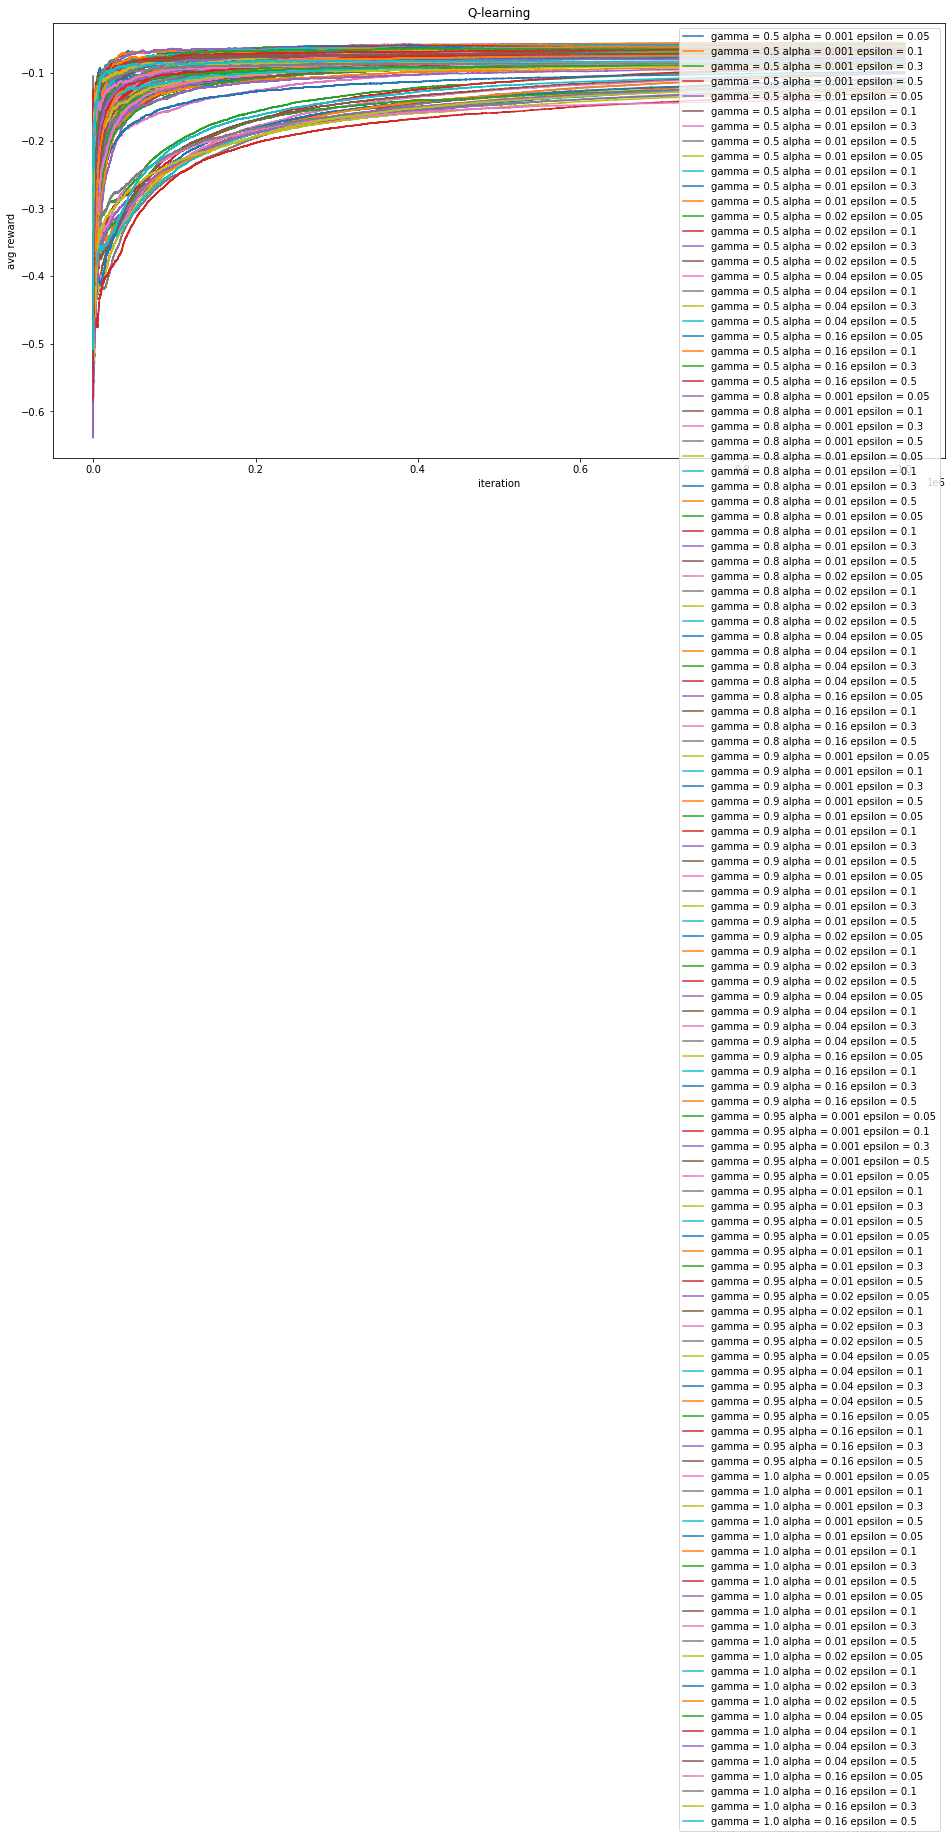

  gamma    alpha    epsilon    Average reward
-------  -------  ---------  ----------------
   0.5     0.001       0.05         -0.11342
   0.5     0.001       0.1          -0.108039
   0.5     0.001       0.3          -0.091283
   0.5     0.001       0.5          -0.088214
   0.5     0.01        0.05         -0.061272
   0.5     0.01        0.1          -0.057321
   0.5     0.01        0.3          -0.05783
   0.5     0.01        0.5          -0.057077
   0.5     0.01        0.05         -0.063408
   0.5     0.01        0.1          -0.059489
   0.5     0.01        0.3          -0.055656
   0.5     0.01        0.5          -0.058928
   0.5     0.02        0.05         -0.056943
   0.5     0.02        0.1          -0.055709
   0.5     0.02        0.3          -0.055655
   0.5     0.02        0.5          -0.055813
   0.5     0.04        0.05         -0.056311
   0.5     0.04        0.1          -0.057047
   0.5     0.04        0.3          -0.058984
   0.5     0.04        0.5          

In [13]:
# Q learning
table = []

plt.figure(figsize=(16, 8))
for gamma in gammas:
    for alpha in alphas:
        for epsilon in epsilons:
            _, rewards = q_learning(env, 1_000_000, gamma = gamma, alpha = alpha, epsilon = epsilon, enable_tqdm=False)
            label = "gamma = " + str(gamma) + " alpha = " + str(alpha) + " epsilon = " + str(epsilon)
            plt.plot(rewards[100:], label = label)
            table.append((gamma, alpha, epsilon, rewards[-1]))

plt.ylabel('avg reward')
plt.xlabel('iteration')
plt.title('Q-learning')
plt.legend()
plt.show()

print(tabulate(table, headers=['gamma', 'alpha', 'epsilon', 'Average reward']))

**4.** Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [27]:
class DoubleBlackjackEnv(MyBlackjackEnv):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.state_size = (32 * 11 * 2) # пространство состояний
        self.action_space_size = (32 * 11 * 2, 3) # пространство состояний и действий
        
        self.seed()
        self.natural = natural
        self.reset()

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        else: # double
            done = True
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
        return self.get_state_index(), reward, done, {}

In [31]:
env2 = DoubleBlackjackEnv(natural = True)

**5.** Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

100%|██████████| 10000000/10000000 [28:42<00:00, 5806.83it/s]


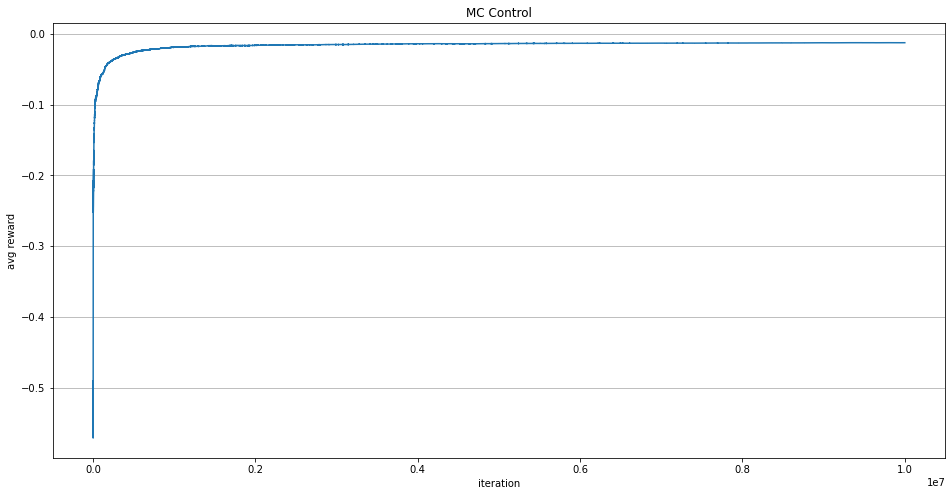

Average reward while learning -0.01272185
Policy reward -0.0111615


In [32]:
pi_mc_env2 = calc_pi_and_plot(env2, MC_control_importance_sampling, "MC Control")
test_pi(env2, pi_mc_env2)

100%|██████████| 10000000/10000000 [28:39<00:00, 5816.40it/s]


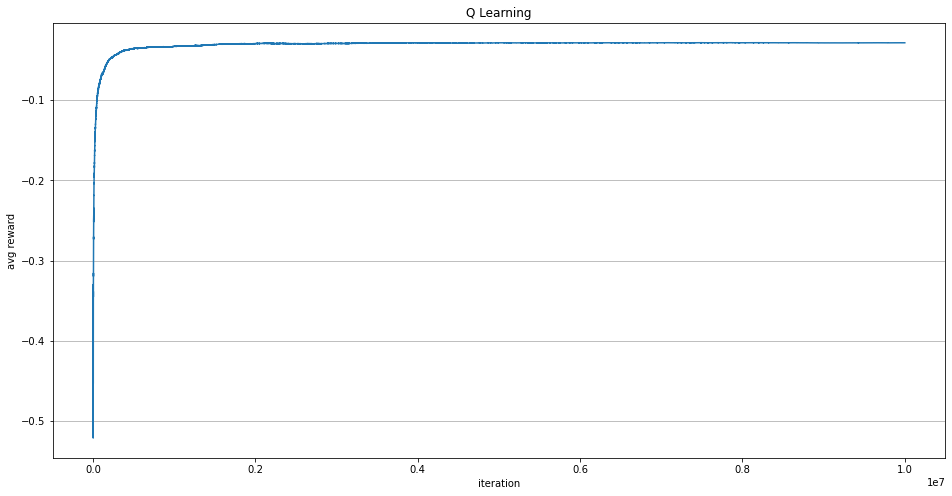

Average reward while learning -0.0284717
Policy reward -0.0262865


In [33]:
pi_q_env2 = calc_pi_and_plot(env2, q_learning, "Q Learning")
test_pi(env2, pi_q_env2)

**6.** Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

In [34]:
# система "Половинки", удвоенные значения
deck_counting_card_price = [-2, 1, 2, 2, 3, 2, 1, 0, -1, -2, -2, -2, -2]
#                   deck = [ 1, 2, 3, 4, 5, 6, 7, 8,  9, 10, 10, 10, 10]

class DoubleCountingBlackjackEnv(MyBlackjackEnv):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.state_size = (32 * 11 * 21 * 2) # пространство состояний
        self.action_space_size = (32 * 11 * 21 * 2, 3) # пространство состояний и действий
        self.seed()
        self.natural = natural
        self.deck_count = 52
        self.deck = np.zeros(13)
        self.deck_counting = 0
        self.deferred_deck_counting_update = 0
        self.reset()
        
    def draw_card(self):
        card_index = np.random.randint(0, self.deck_count)
        current_card_index = 0
        for i in range(0, 13):
            if (self.deck[i] == 4):
                continue
            current_card_index += 4 - self.deck[i]
            if card_index < current_card_index:
                self.deck_count -= 1
                self.deck[i] += 1
                self.deck_counting += deck_counting_card_price[deck[i]]
                return deck[i]
        assert False
        
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                self.deck_counting += self.deferred_deck_counting_update
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            self.deck_counting += self.deferred_deck_counting_update
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        else: # double
            self.deck_counting += self.deferred_deck_counting_update
            done = True
            self.player.append(self.draw_card())
            if is_bust(self.player):
                reward = -2
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card())
                reward = 2 * cmp(score(self.player), score(self.dealer))
        return self.get_state_index(), reward, done, {}
    
    def get_state_index(self):
        deck_counting = self.deck_counting
        if deck_counting > 10:
            deck_counting = 10
        elif deck_counting < 10:
            deck_counting = -10
        return sum_hand(self.player) + 32 * self.dealer[0] + \
            32 * 11 * (deck_counting + 10) + \
            32 * 11 * 21 * usable_ace(self.player)

    def reset(self):
        if self.deck_count < 15: # shuffle deck
            self.deck_count = 52
            self.deck = np.zeros(13)
            self.deck_counting = 0
        self.dealer = self.draw_hand()
        self.deferred_deck_counting_update = deck_counting_card_price[self.dealer[1]]
        self.deck_counting -= self.deferred_deck_counting_update # вторая карта у дилера пока не видна
        self.player = self.draw_hand()
        return self.get_state_index()

In [35]:
env2c = DoubleCountingBlackjackEnv(natural = True)

**7.** Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

100%|██████████| 30000000/30000000 [2:05:07<00:00, 3996.22it/s]  


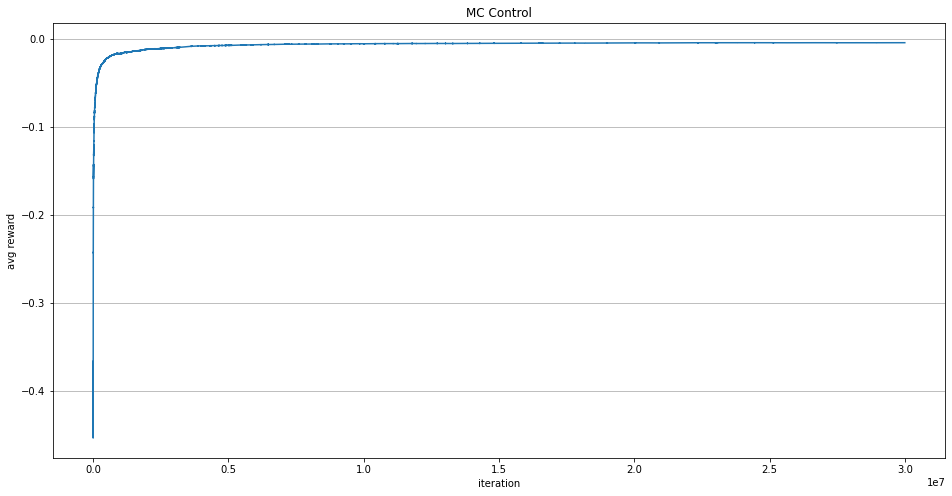

Average reward while learning -0.004648266666666667
Policy reward -0.0046685


In [37]:
pi_mc_env2c = calc_pi_and_plot(env2c, MC_control_importance_sampling, "MC Control", iterations = 30_000_000)
test_pi(env2c, pi_mc_env2c)

100%|██████████| 30000000/30000000 [2:07:08<00:00, 3932.83it/s]  


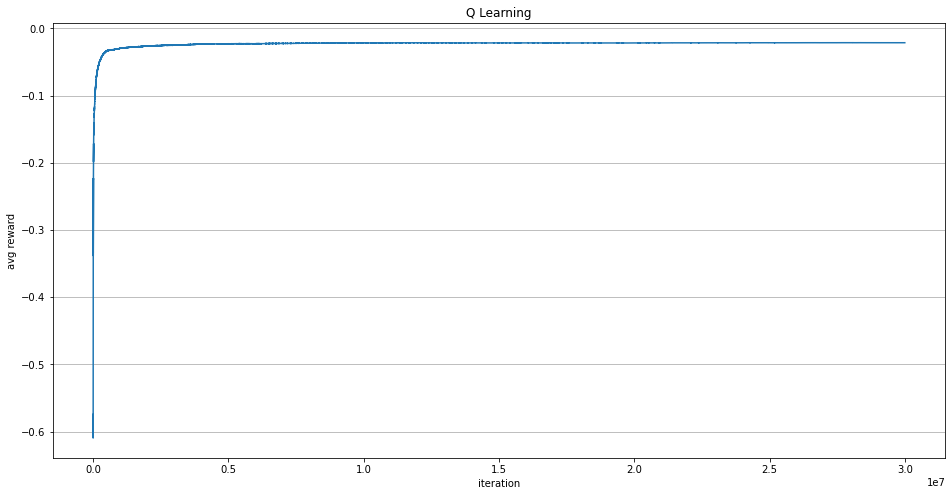

Average reward while learning -0.021463916666666666
Policy reward -0.0304305


In [38]:
pi_q_env2c = calc_pi_and_plot(env2c, q_learning, "Q Learning", iterations = 30_000_000)
test_pi(env2c, pi_q_env2c)

*30_000_000 итераций мало для q learning*

**8.** Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V* или Q*. Для этого вам придётся сначала оценить параметры модели, т.е. вероятности переходов между состояниями.

In [39]:
nA = 2
nS = 32 * 11 * 2 + 1 # + 1 для дополнительного терминального состояния
terminal_state_code = 32 * 11 * 2

# deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

# вероятность вытянуть карту из бесконечной колоды
next_card_probs = [ 
    (1, 1.0 / 13),
    (2, 1.0 / 13),
    (3, 1.0 / 13),
    (4, 1.0 / 13),
    (5, 1.0 / 13),
    (6, 1.0 / 13),
    (7, 1.0 / 13),
    (8, 1.0 / 13),
    (9, 1.0 / 13),
    (10, 4.0 / 13)
]

# вычислить средний reward в терминальном состоянии (после действия stick игрока)
def calc_average_reward(player_hand_sum, dealer_first_card):
    if player_hand_sum > 21:
        return -1.0
    # текущая рука дилера
    # терминальное состояние
    # вероятность состояния
    # выигрыш
    after_stick_states = [([dealer_first_card], False, 1.0, 0)]
    has_unvisited_states= True
    while has_unvisited_states:
        has_unvisited_states = False
        after_stick_states_2 = []
        for state in after_stick_states:
            if state[1]:
                after_stick_states_2.append(state)
            else:
                has_unvisited_states = True
                for next_card, next_card_proba in next_card_probs:
                    new_hand = state[0].copy()
                    new_hand.append(next_card)
                    after_stick_states_2.append((new_hand, sum_hand(new_hand) >= 17, next_card_proba * state[2], cmp(player_hand_sum, score(new_hand))))
        after_stick_states = after_stick_states_2
    reward = 0.0
    for state in after_stick_states:
        assert state[1]
        reward += state[2] * state[3]
    return reward

# print(calc_average_reward(19, 5))

# # стохастически вычислить средний reward в терминальном состоянии (после действия stick игрока)
# def calc_average_reward_stochastic(player_hand_sum, dealer_first_card):
#     for _ in tqdm(range(1000000)):
#         dealer_hand = [dealer_first_card, draw_card(env.np_random)]
#         while sum_hand(dealer_hand) < 17:
#             dealer_hand.append(draw_card(env.np_random))
#         if is_bust(dealer_hand):
#             rewards.append(1.0)
#         else:
#             rewards.append(cmp(player_hand_sum, score(dealer_hand)))
#     return np.array(rewards).mean()

# print(calc_average_reward_stochastic(19, 5))

# выигрыш игрока после действия stick при определенной сумме его руки и первой карте дилера
stick_rewards = np.zeros((32, 11), dtype=float)
for i in tqdm(range(0, 32)):
    for j in range(0, 11):
        stick_rewards[i][j] = calc_average_reward(i, j)

100%|██████████| 32/32 [00:06<00:00,  4.74it/s]


In [40]:
# вычислить индекс состояния
def calc_state_index(player_hand, dealer_first_card):
    return sum_hand(player_hand) + 32 * dealer_first_card + 32 * 11 * usable_ace(player_hand)

# вычислить вероятность перехода и выигрыши по состоянию
def calc_next_P(player_hand, dealer_first_card):
    new_player_hands = []
    hits = []
    for card, proba in next_card_probs:
        new_player_hand = player_hand.copy()
        new_player_hand.append(card)
        new_player_hands.append(new_player_hand)
        is_terminal = is_bust(new_player_hand)
        # формат перехода Q[s][a] -> s_target:
        # вероятность
        # индекс s_target
        # выигрыш
        # признак терминального состояния
        if is_terminal:
            hits.append((proba, terminal_state_code, -1.0, True))
        else:
            hits.append((proba, calc_state_index(new_player_hand, dealer_first_card), 0.0, False))
    stick = [(1.0, terminal_state_code, stick_rewards[sum_hand(player_hand)][dealer_first_card], True)]
    return { 0: stick, 1: hits }, new_player_hands

# вычислить все возможные переходы
def calc_P():
    P = { terminal_state_code: { 
        0: [(1.0, terminal_state_code, 0.0, True)], 
        1: [(1.0, terminal_state_code, 0.0, True)] } 
        }
    hands = []
    for card0, _ in next_card_probs:
        for card1, _ in next_card_probs:
            hands.append([card0, card1])

    has_unvisited_p = True
    while has_unvisited_p:
        has_unvisited_p = False
        hands_2 = []
        for hand in hands:
            for dealer_first_card in range(1, 11):
                state_index = calc_state_index(hand, dealer_first_card)
                if not state_index in P:
                    has_unvisited_p = True
                    p, new_hands = calc_next_P(hand, dealer_first_card)
                    for new_hand in new_hands:
                        if sum_hand(new_hand) < 32:
                            hands_2.append(new_hand)
                    P[state_index] = p
        hands = hands_2
    
    impossible_states = []
    for i in range(nS):
        if not i in P:
            impossible_states.append(i)
            P[i] = { 
                0: [(1.0, terminal_state_code, 0.0, True)], 
                1: [(1.0, terminal_state_code, 0.0, True)]
            }
    impossible_states.append(terminal_state_code)
    
    return P, impossible_states

In [41]:
P, impossible_states = calc_P()

In [42]:
final_states = impossible_states

# Взято из вашего ноутбука №2 as is:

def get_random_V():
    V = np.random.random(nS)
    V[final_states] = 0.0
    return V

def get_random_Q():
    Q = np.random.random(size=(nS, nA))
    Q[final_states, :] = 0.0
    return Q

def compute_V_by_policy(pi, gamma=1.0):
    V = get_random_V()
    while True:
        new_V = np.array([ \
          np.sum([ x[0] * ( x[2] + gamma * V[x[1]] ) for x in P[cur_state][pi[cur_state]] ]) \
        for cur_state in range(nS) ])
        if np.sum((V - new_V) ** 2) < 0.001:
            break
        V = new_V
    return V

def compute_policy_by_V(V, gamma=1.0):
    return np.argmax( np.array([[ \
          np.sum([ x[0] * ( x[2] + gamma * V[x[1]] ) for x in P[s][a] ]) \
        for a in range(nA) ] for s in range(nS)]), axis=1 )

def compute_V_and_pi(gamma=1.0):
    V = get_random_V()
    pi = np.random.randint(nA, size = nS)

    while True:
        V = compute_V_by_policy(pi, gamma)
        new_pi = compute_policy_by_V(V, gamma)
        if np.array_equal(pi, new_pi):
            break
        pi = new_pi
    
    return V, pi

In [43]:
def format_pi(pi_bellman):
    pi = np.zeros(env.action_space_size)
    for i in range(env.action_space_size[0]):
        if pi_bellman[i] == 0:
            pi[i][0] = 1.0
        else:
            pi[i][1] = 1.0
    return pi

In [44]:
V, pi_bellman = compute_V_and_pi()
pi_bellman = format_pi(pi_bellman)

In [45]:
print("Результат стратегии, полученной policy iteration по уравнениям Беллмана: ")
test_pi(env, pi_bellman)

Результат стратегии, полученной policy iteration по уравнениям Беллмана: 
Policy reward -0.0272075


Результат очень близкий к стратегии, полученной MC Control.
Сравним их:

In [46]:
def decode_state(state_index):
# state_index= sum_hand(player_deck) + 32 * dealer_first_card + 32 * 11 * usable_ace(player_deck)
    if state_index == terminal_state_code:
        return -1, 0, 0
    a = state_index
    usable_ace = a > 32 * 11
    if usable_ace:
        a -= 32 * 11
    dealer_first_card = a // 32
    sum_hand = a - dealer_first_card * 32
    assert state_index == sum_hand + 32 * dealer_first_card + 32 * 11 * usable_ace
    return sum_hand, dealer_first_card, usable_ace

def compare_policies(pi, pi_bellman):
    diff_count = 0
    set_impossible_states = set(impossible_states)
    for i in range(nS):
        if not i in set_impossible_states and (pi_bellman[i] != pi_mc_env[i]).all():
            sum_hand, dealer_first_card, usable_ace = decode_state(i)
            if sum_hand > 21:
                continue
            print("Расхождение в ( сумма карт=" + str(sum_hand) + ", карта дилера=" + str(dealer_first_card) + 
                  ", usable_ace=" + str(usable_ace) + ", V[s]=" + str(V[i]) + ")")
            diff_count += 1
    print("Всего расхождений: " + str(diff_count))
    
compare_policies(pi_mc_env, pi_bellman)    

Расхождение в ( сумма карт=12, карта дилера=4, usable_ace=False, V[s]=-0.21106310899491507)
Всего расхождений: 1


**9.** Реализуйте вариант из второй или третьей части, в котором есть ещё возможность делать split: в случае, когда игроку пришли две одинаковые карты, он может разбить руку на две, внести ещё одну ставку и продолжать играть две руки сразу (как будто за двоих игроков). Скорее всего, обыграть казино получится только в варианте с разрешённым split’ом и подсчётом карт; если получится, это будет отличное завершение проекта!

Игра несколько упрощена:  

- вместо того, чтобы после сплита играть вторую игру тоже со сплитами, она играется без сплитов (но со счетом карт и удвоениям). Это - легальное сужение пространства возможных действий.
- при исчерпании колоды объявляется ничья, это сделано для упрощения кода и не влияет на результат - примерно одно исчерпание на 500_000 игр

In [47]:
# система "Половинки", удвоенные значения
# deck_counting_card_price = [-2, 1, 2, 2, 3, 2, 1, 0, -1, -2, -2, -2, -2]
#                     deck = [ 1, 2, 3, 4, 5, 6, 7, 8,  9, 10, 10, 10, 10]

class DoubleCountingSplitBlackjackEnv(MyBlackjackEnv):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.state_size = (32 * 11 * 21 * 2 * 11) # пространство состояний
        # 31 - максимальная сумма руки игрока
        # 10 - максимальный номинал первой карты игрока
        # 10 - максимальный номинал видимой карты дилера
        # 21 - счет карт
        # 2 - usable_ace
        # 11 - 0, если нельзя сплиттить, иначе номинал карты, которая остается после сплита
        self.action_space_size = (32 * 11 * 21 * 2 * 11, 4) # пространство состояний и действий
        self.seed()
        self.natural = natural
        self.deck_count = 52
        self.deck = np.zeros(13)
        self.deck_counting = 0
        self.deferred_deck_counting_update = 0
        self.pi = None
        self.split_count = 0
        self.splitted_game_played = False
        self.player = [1, 1]
        self.dealer = [1, 1]
        self.reset()
        
    def draw_card(self):
        if self.deck_count == 0:
            raise Exception("deck is empty")
        card_index = np.random.randint(0, self.deck_count)
        current_card_index = 0
        for i in range(0, 13):
            if (self.deck[i] == 4):
                continue
            current_card_index += 4 - self.deck[i]
            if card_index < current_card_index:
                self.deck_count -= 1
                self.deck[i] += 1
                self.deck_counting += deck_counting_card_price[deck[i]]
                return deck[i]
        assert False
        
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]

    def step(self, action):
        assert self.action_space.contains(action)
        try:
            if action == 1:  # hit: add a card to players hand and return
                self.player.append(self.draw_card())
                if is_bust(self.player):
                    self.deck_counting += self.deferred_deck_counting_update
                    done = True
                    reward = -1.
                else:
                    done = False
                    reward = 0.
            elif action == 0:  # stick: play out the dealers hand, and score
                self.deck_counting += self.deferred_deck_counting_update
                done = True
                if not self.splitted_game_played:
                    while sum_hand(self.dealer) < 17:
                        self.dealer.append(self.draw_card())
                reward = cmp(score(self.player), score(self.dealer))
                if self.natural and is_natural(self.player) and reward == 1.:
                    reward = 1.5
            elif action == 2: # double
                self.deck_counting += self.deferred_deck_counting_update
                done = True
                self.player.append(self.draw_card())
                if is_bust(self.player):
                    reward = -2.0
                else:
                    if not self.splitted_game_played:
                        while sum_hand(self.dealer) < 17:
                            self.dealer.append(draw_card(self.np_random))
                    reward = 2 * cmp(score(self.player), score(self.dealer))
            else: # split
                if self.can_split():
                    self.split_count += 1
                    splitted_player_hand = [self.player[1], self.draw_card()]
                    self.player = [self.player[0], self.draw_card()]
                    reward = self.play_splitted_game(splitted_player_hand)
                    done = False
                else:
                    reward = -1.0
                    self.deck_counting += self.deferred_deck_counting_update
                    done = True
            return self.get_state_index(), reward, done, {}
        except Exception: # карты в колоде кончились
            assert self.deck_count == 0
            return self.get_state_index(), 0.0, True, {}
    
    
    # побочная игра проходит без сплитов по правилам со счетом карт и удвоением
    def play_splitted_game(self, player_hand):
        pi = self.pi
        for _ in range(1000):
            state_index = self.get_splitted_game_state_index(player_hand)
            pi_probabilities = pi[state_index]
            next_action = np.random.choice(np.arange(len(pi_probabilities)), p = pi_probabilities)
            _, reward, done, _ = self.splitted_game_step(player_hand, next_action)
            if done:
                return reward
    
    def splitted_game_step(self, player_hand, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            player_hand.append(self.draw_card())
            if is_bust(player_hand):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            if not self.splitted_game_played:
                self.splitted_game_played = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card())
            reward = cmp(score(player_hand), score(self.dealer))
            if self.natural and is_natural(player_hand) and reward == 1.:
                reward = 1.5
        elif action == 2: # double
            done = True
            player_hand.append(self.draw_card())
            if is_bust(player_hand):
                reward = -2
            else:
                if not self.splitted_game_played:
                    self.splitted_game_played = True
                    while sum_hand(self.dealer) < 17:
                        self.dealer.append(self.draw_card())
                reward = 2 * cmp(score(player_hand), score(self.dealer))
        else: # split is forbidden
            done = True
            reward = -1.0
        return self.get_splitted_game_state_index(player_hand), reward, done, {}
    
    def get_splitted_game_state_index(self, player_hand):
        split_factor = 0
        deck_counting = self.deck_counting
        if deck_counting > 10:
            deck_counting = 10
        elif deck_counting < 10:
            deck_counting = -10
        return sum_hand(player_hand) + \
            32 * self.dealer[0] + \
            32 * 11 * (deck_counting + 10) + \
            32  * 11 * 21 * usable_ace(player_hand) + \
            32  * 11 * 21 * 2 * split_factor
    
    def get_state_index(self):
        split_factor = self.player[0] if self.can_split() else 0
        deck_counting = self.deck_counting
        if deck_counting > 10:
            deck_counting = 10
        elif deck_counting < 10:
            deck_counting = -10
        return sum_hand(self.player) + \
            32 * self.dealer[0] + \
            32 * 11 * (deck_counting + 10) + \
            32  * 11 * 21 * usable_ace(self.player) + \
            32  * 11 * 21 * 2 * split_factor

    def can_split(self):
        return len(self.player) == 2 and self.player[0] == self.player[1] and self.split_count < 3
    
    def reset(self):
        if self.deck_count < 15: # shuffle deck
            self.deck_count = 52
            self.deck = np.zeros(13)
            self.deck_counting = 0
        self.dealer = self.draw_hand()
        self.deferred_deck_counting_update = deck_counting_card_price[self.dealer[1]]
        self.deck_counting -= self.deferred_deck_counting_update # вторая карта у дилера пока не видна
        self.player = self.draw_hand()
        self.split_count = 0
        self.splitted_game_played = False
        return self.get_state_index()

In [48]:
env2cs = DoubleCountingSplitBlackjackEnv(natural = True)

100%|██████████| 50000000/50000000 [3:23:44<00:00, 4089.99it/s]  


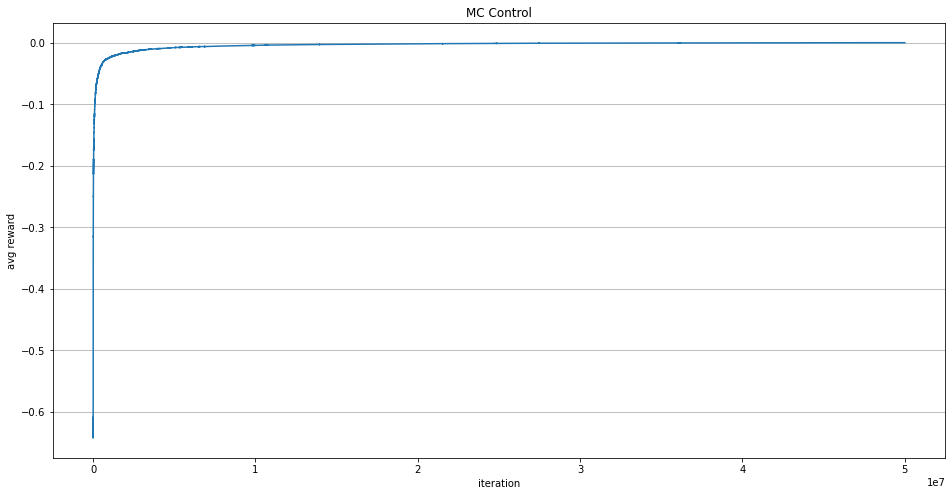

Average reward while learning 8.334e-05
Policy reward -0.0002775


In [19]:
pi_mc_env2cs = calc_pi_and_plot(env2cs, MC_control_importance_sampling, "MC Control", iterations = 50_000_000)
test_pi(env2cs, pi_mc_env2cs)

Почти вышли в ноль, но увы, house always wins.

Посмотрим, когда наша стратегия делает сплит:

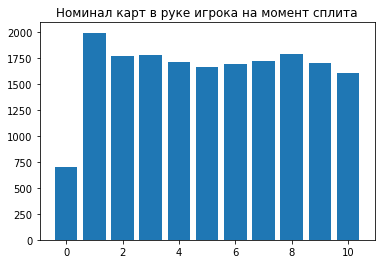

In [52]:
def decode_state(state_index):
    a = state_index
    split_factor = a // (32  * 11 * 21 * 2)
    a -= split_factor * 32  * 11 * 21 * 2
    usable_ace = a > 32 * 11 * 21
    if usable_ace:
        a -= 32 * 11 * 21
    deck_counting = a // (32 * 11)
    a -= deck_counting * 32 * 11
    deck_counting -= 10
    dealer_first_card = a // 32
    sum_hand = a - dealer_first_card * 32
    x = sum_hand + \
            32 * dealer_first_card + \
            32 * 11 * (deck_counting + 10) + \
            32  * 11 * 21 * usable_ace + \
            32  * 11 * 21 * 2 * split_factor
    assert state_index == x
    return sum_hand, dealer_first_card, usable_ace, deck_counting, split_factor

def get_stats_2cs():
    count = 0
    split_count = 0
    split_cards = np.zeros((11))
    sum_hands = np.zeros((32))
    deck_countings = np.zeros((21))
    dealer_first_cards = np.zeros((11))
    for i in range(32  * 11 * 21 * 11 * 2):
        sum_hand, dealer_first_card, usable_ace, deck_counting, split_factor = decode_state(i)
        # отсев незначимых состояний, которые невозможны или в которых любое действие приводит к поражению:
        if sum_hand < 4 or sum_hand > 21 or dealer_first_card < 1 or dealer_first_card > 10:
            continue
        count += 1
        if pi_mc_env2cs[i][3] == 1.0:
            split_count += 1
            split_cards[split_factor] += 1
            dealer_first_cards[dealer_first_card] += 1
            deck_countings[deck_counting] += 1
            sum_hands[sum_hand] += 1
    plt.bar(np.arange(len(split_cards)), split_cards)
    plt.title("Номинал карт в руке игрока на момент сплита")
    plt.show()
    
get_stats_2cs()

Стратегия коррелирует с базовыми правилами, [когда делать сплит](https://www.wikihow.com/Know-when-to-Split-Pairs-in-Blackjack):

  - всегда делать сплит для пары тузов или восьмерок
  - никогда не делать сплит пятерок или десяток

100%|██████████| 50000000/50000000 [3:28:08<00:00, 4003.62it/s]  


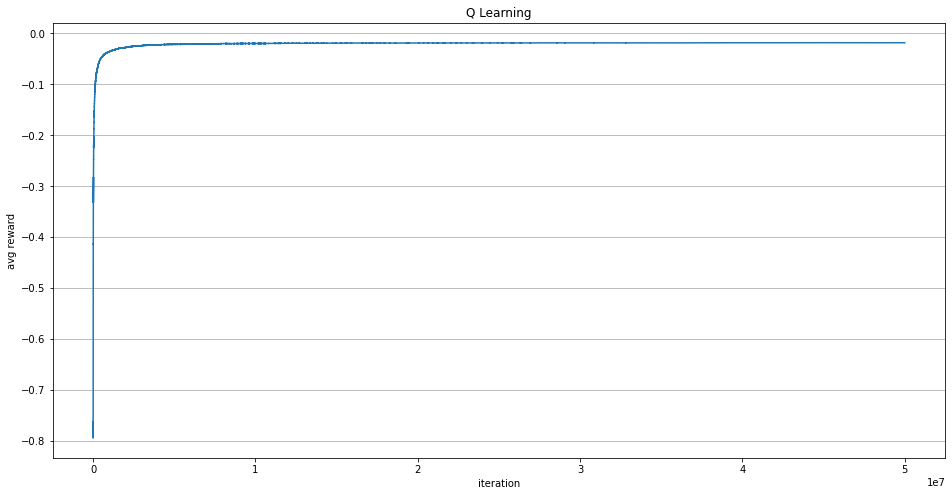

Average reward while learning -0.01825431
Policy reward -0.0169355


In [53]:
pi_q_env2cs = calc_pi_and_plot(env2cs, q_learning, "Q Learning", iterations = 50_000_000)
test_pi(env2cs, pi_q_env2cs)

**Итого:**
    
| Игра                                        | Размерность пространства<br> состояний x действий | Итераций    | Средний выигрыш<br> MC | Средний выигрыш<br> Q Learning |
|---------------------------------------------|-----------------------------------------------|-------------|--------------------|----------------------------|
| Простая                                     | 704 x 2                                       | 10_000_000  | -0.025429          | -0.032569                  |
| С удвоениями ставки                         | 704 x 3                                       | 10_000_000  | -0.011162          | -0.026287                  |
| С удвоениями ставки и счетом карт           | 14_784 x 3                                    | 30_000_000 | -0.004669          | -0.030431                  |
| С удвоениями ставки, счетом карт и сплитами | 162_624 x 4                                   | 50_000_000 | -0.000278                  | -0.016936             |    